In [1]:
import cv2
from datetime import timedelta
import matplotlib.pyplot as plt
import numpy as np
import odc.stac
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import geopy.distance as distance
import rioxarray
from multiprocessing import Pool, Manager

%matplotlib inline

In [2]:
# Establish a connection to the STAC API
import planetary_computer as pc
from pystac_client import Client

catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace
)

In [3]:
metadata = pd.read_csv('../data/metadata.csv')

In [4]:
# get our bounding box to search latitude and longitude coordinates
def get_bounding_box(latitude, longitude, meter_buffer=50000):
    """
    Given a latitude, longitude, and buffer in meters, returns a bounding
    box around the point with the buffer on the left, right, top, and bottom.

    Returns a list of [minx, miny, maxx, maxy]
    """
    distance_search = distance.distance(meters=meter_buffer)

    # calculate the lat/long bounds based on ground distance
    # bearings are cardinal directions to move (south, west, north, and east)
    min_lat = distance_search.destination((latitude, longitude), bearing=180)[0]
    min_long = distance_search.destination((latitude, longitude), bearing=270)[1]
    max_lat = distance_search.destination((latitude, longitude), bearing=0)[0]
    max_long = distance_search.destination((latitude, longitude), bearing=90)[1]

    return [min_long, min_lat, max_long, max_lat]

In [5]:
# get our date range to search, and format correctly for query
def get_date_range(date, time_buffer_days=15):
    """Get a date range to search for in the planetary computer based
    on a sample's date. The time range will include the sample date
    and time_buffer_days days prior

    Returns a string"""
    datetime_format = "%Y-%m-%d"
    range_start = pd.to_datetime(date) - timedelta(days=time_buffer_days)
    date_range = f"{range_start.strftime(datetime_format)}/{pd.to_datetime(date).strftime(datetime_format)}"

    return date_range


In [6]:
example_row = metadata[metadata.uid == "garm"].iloc[0]
example_row

uid                garm
latitude       41.98006
longitude    -110.65734
date         2021-09-27
split             train
Name: 5461, dtype: object

In [7]:
bbox = get_bounding_box(example_row.latitude, example_row.longitude, meter_buffer=50000)
bbox

[-111.26063646639783,
 41.52988747516146,
 -110.05404353360218,
 42.43019710235757]

In [8]:
date_range = get_date_range(example_row.date, 15)
date_range

'2021-09-12/2021-09-27'

In [9]:
# search the planetary computer sentinel-l2a and landsat level-2 collections
search = catalog.search(
    collections=["sentinel-2-l2a", "landsat-c2-l2"], bbox=bbox, datetime=date_range
)

# see how many items were returned
items = [item for item in search.item_collection()]
len(items)

46

In [10]:
# get details of all of the items returned
item_details = pd.DataFrame(
    [
        {
            "datetime": item.datetime.strftime("%Y-%m-%d"),
            "platform": item.properties["platform"],
            "min_long": item.bbox[0],
            "max_long": item.bbox[2],
            "min_lat": item.bbox[1],
            "max_lat": item.bbox[3],
            "bbox": item.bbox,
            "item_obj": item,
        }
        for item in items
    ]
)

# check which rows actually contain the sample location
item_details["contains_sample_point"] = (
    (item_details.min_lat < example_row.latitude)
    & (item_details.max_lat > example_row.latitude)
    & (item_details.min_long < example_row.longitude)
    & (item_details.max_long > example_row.longitude)
)

print(
    f"Filtering from {len(item_details)} returned to {item_details.contains_sample_point.sum()} items that contain the sample location"
)

item_details = item_details[item_details["contains_sample_point"]]
item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
    by="datetime"
)

Filtering from 46 returned to 7 items that contain the sample location


,datetime,platform,contains_sample_point,bbox
44,2021-09-12,landsat-8,True,"[-111.34023745, 40.67702495, -108.51528663, 42..."
34,2021-09-14,Sentinel-2A,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
21,2021-09-19,Sentinel-2B,True,"[-111.000244, 41.45624189757688, -109.665115, ..."
26,2021-09-19,landsat-8,True,"[-112.92522743, 40.67353498, -110.06644659, 42..."
18,2021-09-20,landsat-7,True,"[-111.60018779, 40.80284495, -108.59831681, 42..."
8,2021-09-24,Sentinel-2A,True,"[-111.000244, 41.4562419, -109.665115, 42.4526..."
5,2021-09-27,landsat-7,True,"[-113.18385774, 40.78803499, -110.15150674, 42..."


In [11]:
# 1 - filter to sentinel
item_details[item_details.platform.str.contains("Sentinel")]

,datetime,platform,min_long,max_long,min_lat,max_lat,bbox,item_obj,contains_sample_point
8,2021-09-24,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.4562419, -109.665115, 42.4526...",<Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...,True
21,2021-09-19,Sentinel-2B,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2B_MSIL2A_20210919T180919_R084_T12TW...,True
34,2021-09-14,Sentinel-2A,-111.000244,-109.665115,41.456242,42.452691,"[-111.000244, 41.45624189757688, -109.665115, ...",<Item id=S2A_MSIL2A_20210914T180951_R084_T12TW...,True


In [12]:
# 2 - take closest by date
best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
)
best_item

datetime                                                        2021-09-24
platform                                                       Sentinel-2A
min_long                                                       -111.000244
max_long                                                       -109.665115
min_lat                                                          41.456242
max_lat                                                          42.452691
bbox                     [-111.000244, 41.4562419, -109.665115, 42.4526...
item_obj                 <Item id=S2A_MSIL2A_20210924T181101_R084_T12TW...
contains_sample_point                                                 True
Name: 8, dtype: object

In [13]:
item = best_item.item_obj

In [14]:
# What assets are available?
for asset_key, asset in item.assets.items():
    print(f"{asset_key:<25} - {asset.title}")

AOT                       - Aerosol optical thickness (AOT)
B01                       - Band 1 - Coastal aerosol - 60m
B02                       - Band 2 - Blue - 10m
B03                       - Band 3 - Green - 10m
B04                       - Band 4 - Red - 10m
B05                       - Band 5 - Vegetation red edge 1 - 20m
B06                       - Band 6 - Vegetation red edge 2 - 20m
B07                       - Band 7 - Vegetation red edge 3 - 20m
B08                       - Band 8 - NIR - 10m
B09                       - Band 9 - Water vapor - 60m
B11                       - Band 11 - SWIR (1.6) - 20m
B12                       - Band 12 - SWIR (2.2) - 20m
B8A                       - Band 8A - Vegetation red edge 4 - 20m
SCL                       - Scene classfication map (SCL)
WVP                       - Water vapour (WVP)
visual                    - True color image
preview                   - Thumbnail
safe-manifest             - SAFE manifest
granule-metadata          - Granul

In [15]:
def crop_sentinel_image(item, bounding_box, band):
    """
    Given a STAC item from Sentinel-2 and a bounding box tuple in the format
    (minx, miny, maxx, maxy), return a cropped portion of the item's visual
    imagery in the bounding box.

    Returns the image as a numpy array with dimensions (color band, height, width)
    """
    (minx, miny, maxx, maxy) = bounding_box

    image = rioxarray.open_rasterio(pc.sign(item.assets[band].href)).rio.clip_box(
        minx=minx,
        miny=miny,
        maxx=maxx,
        maxy=maxy,
        crs="EPSG:4326",
    )

    return image.to_numpy()

In [16]:
%%time

minx, miny, maxx, maxy = get_bounding_box(
    example_row.latitude, example_row.longitude, meter_buffer=3000
)

# get the zoomed in image array
bbox = (minx, miny, maxx, maxy)

true_color = crop_sentinel_image(item, bbox, "visual")
scl = crop_sentinel_image(item, bbox, "SCL")[0]
nir = crop_sentinel_image(item, bbox, "B08")

CPU times: user 101 ms, sys: 28.4 ms, total: 130 ms
Wall time: 19.3 s


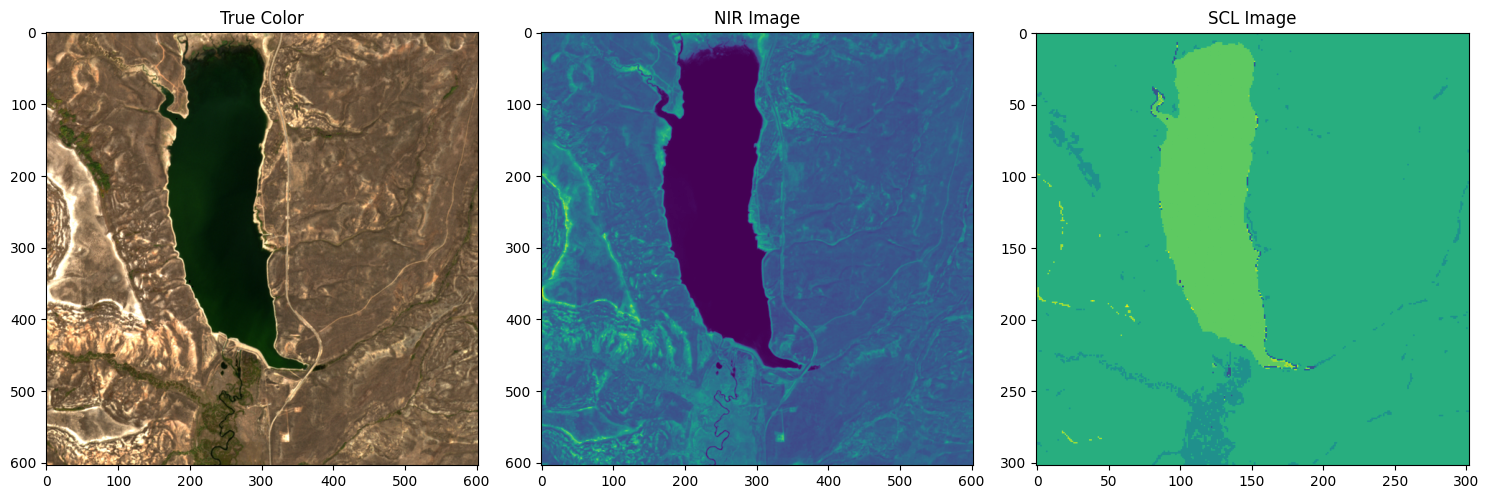

In [17]:
# Crear subplots con una fila y tres columnas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar la primera imagen en el primer subplot
axs[0].imshow(np.transpose(true_color, axes=[1, 2, 0]))
axs[0].set_title('True Color')

# Mostrar la segunda imagen en el segundo subplot
axs[1].imshow(np.transpose(nir, axes=[1, 2, 0]))
axs[1].set_title('NIR Image')

# Mostrar la tercera imagen en el tercer subplot
axs[2].imshow(scl)
axs[2].set_title('SCL Image')

# Ajustar diseño
plt.tight_layout()
# Mostrar los subplots
plt.show()

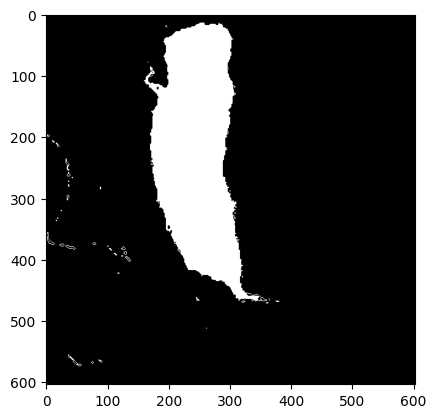

In [18]:
visual = np.transpose(true_color, axes=[1, 2, 0])
water_mask = np.stack([cv2.resize(scl, (visual.shape[1], visual.shape[0]))] * 3, -1) == 6
water_mask = np.where(water_mask, 255, 0)
plt.imshow(water_mask)

In [56]:
# Get images
def get_images(row):
    """
    Given a row from the metadada, return 3 cropped images from sentinel
    1. True color image
    2. NIR image
    3. Water mask
    """
    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)
    date_range = get_date_range(row.date)
    
    # search the planetary computer sentinel-l2a and landsat level-2 collections
    search = catalog.search(
        collections=["sentinel-2-l2a"], 
        bbox=bbox, 
        datetime=date_range
    )
    
    # get items
    items = [item for item in search.item_collection()]
    
    # get details of all of the items returned
    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "bbox": item.bbox,
                "item_obj": item,
            }
            for item in items
        ]
    )
    
    # check which rows actually contain the sample location
    item_details["contains_sample_point"] = (
        (item_details.min_lat < row.latitude)
        & (item_details.max_lat > row.latitude)
        & (item_details.min_long < row.longitude)
        & (item_details.max_long > row.longitude)
    )
    item_details = item_details[item_details["contains_sample_point"]]
    item_details[["datetime", "platform", "contains_sample_point", "bbox"]].sort_values(
        by="datetime"
    )
    
    #Get best item
    best_item = (
    item_details[item_details.platform.str.contains("Sentinel")]
    .sort_values(by="datetime", ascending=False)
    .iloc[0]
    )
    item = best_item.item_obj

    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)
    true_color = crop_sentinel_image(item, bbox, "visual")
    scl = crop_sentinel_image(item, bbox, "SCL")[0]
    nir = crop_sentinel_image(item, bbox, "B08")
    
    # transpose
    nir = np.transpose(nir, axes=[1, 2, 0])
    visual = np.transpose(true_color, axes=[1, 2, 0])
    water_mask = np.stack([cv2.resize(scl, (visual.shape[1], visual.shape[0]))] * 3, -1) == 6
    water_mask = np.where(water_mask, 1, nan)
    
    # Return images
    return visual, nir, water_mask

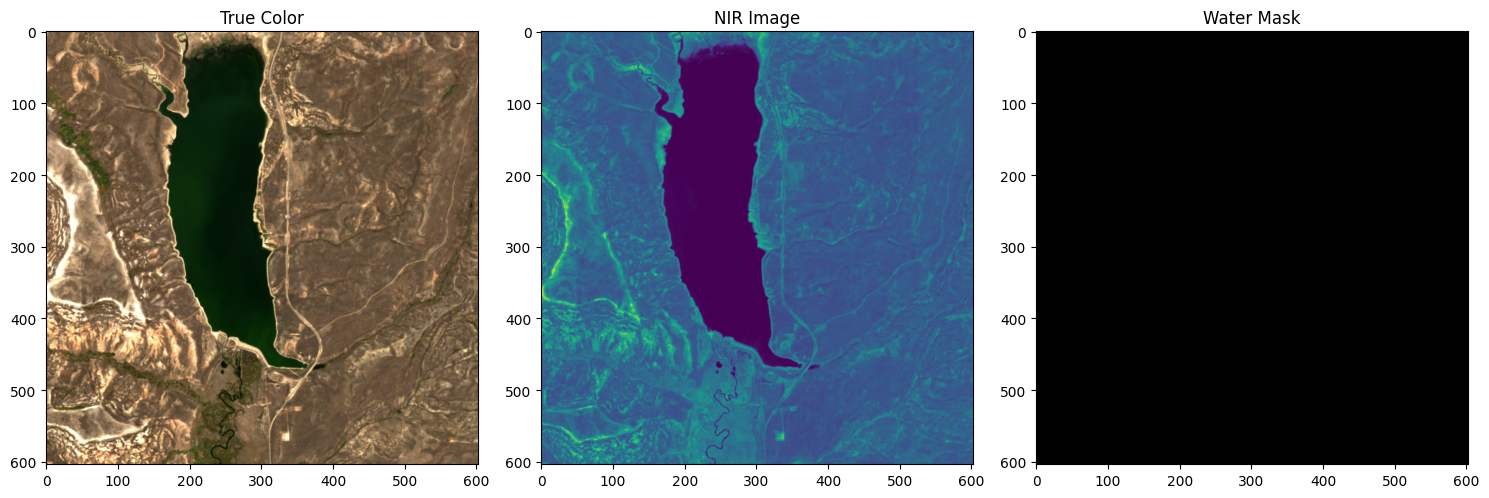

CPU times: user 969 ms, sys: 1.33 s, total: 2.3 s
Wall time: 18.9 s


In [57]:
%%time 

test_visual, test_nir, test_water_mask = get_images(example_row)

# Crear subplots con una fila y tres columnas
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Mostrar la primera imagen en el primer subplot
axs[0].imshow(test_visual)
axs[0].set_title('True Color')

# Mostrar la segunda imagen en el segundo subplot
axs[1].imshow(test_nir)
axs[1].set_title('NIR Image')

# Mostrar la tercera imagen en el tercer subplot
axs[2].imshow(test_water_mask)
axs[2].set_title('Water Mask')

# Ajustar diseño
plt.tight_layout()
# Mostrar los subplots
plt.show()

In [43]:
def get_valid_data_points(row, valid_points):
    """
    Given a row from the metadada, return true if data can be extracted from data point
    """
    bbox = get_bounding_box(row.latitude, row.longitude, meter_buffer=3000)
    date_range = get_date_range(row.date)
    
    # search the planetary computer sentinel-l2a and landsat level-2 collections
    search = catalog.search(
        collections=["sentinel-2-l2a"], 
        bbox=bbox, 
        datetime=date_range
    )
    
    # get items
    items = [item for item in search.item_collection()]

    item_details = pd.DataFrame(
        [
            {
                "datetime": item.datetime.strftime("%Y-%m-%d"),
                "platform": item.properties["platform"],
                "min_long": item.bbox[0],
                "max_long": item.bbox[2],
                "min_lat": item.bbox[1],
                "max_lat": item.bbox[3],
                "bbox": item.bbox,
                "item_obj": item,
            }
            for item in items
        ]
    )
    
    item_details["contains_sample_point"] = (
        (item_details.min_lat < row.latitude)
        & (item_details.max_lat > row.latitude)
        & (item_details.min_long < row.longitude)
        & (item_details.max_long > row.longitude)
    )
    item_details = item_details[item_details["contains_sample_point"]]
    
    if len(item_details) == 0:
        pass
    else:
        valid_points.append(row)
    

In [22]:
test_row = metadata[metadata.uid == "aaoj"].iloc[0]
test_row

uid                aaoj
latitude        38.0201
longitude      -122.259
date         2015-07-07
split             train
Name: 19, dtype: object

In [46]:
%%time
p = Pool(processes=32)
manager = Manager()
valid_points = manager.list()

for i, r in tqdm(metadata.iterrows()):
    p.apply_async(get_valid_data_points, (r, valid_points, ))
p.close()
p.join()


23570it [00:01, 21779.49it/s]


CPU times: user 7.72 s, sys: 1.6 s, total: 9.32 s
Wall time: 2min 30s


In [47]:
len(valid_points)

16263

In [48]:
len(metadata)

23570

In [49]:
len(valid_points)/len(metadata)

0.6899872719558762

In [50]:
test_nir.shape

(604, 603, 1)

In [51]:
test_visual.shape

(604, 603, 3)

In [55]:
test_water_mask.shape

(604, 603, 3)

In [58]:
test_result = test_visual * test_water_mask

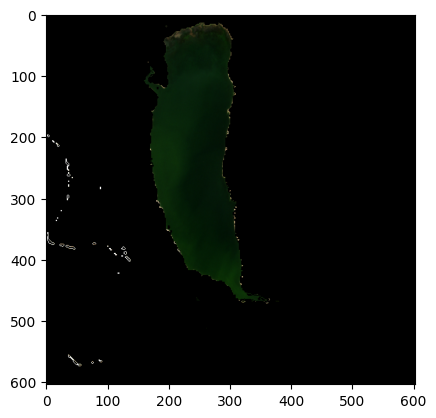

In [59]:
plt.imshow(test_result)

In [60]:
mascara_gris = np.any(test_water_mask, axis=2, keepdims=True).astype(int)

In [61]:
mascara_gris.shape

(604, 603, 1)

In [62]:
test_result = test_visual * mascara_gris

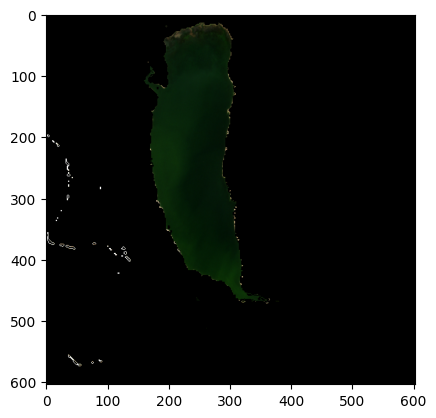

In [63]:
plt.imshow(test_result)

In [64]:
test_result = test_nir * mascara_gris

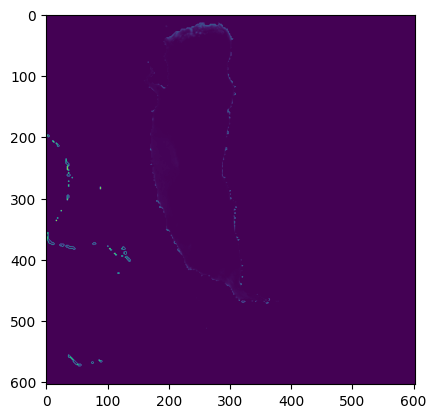

In [65]:
plt.imshow(test_result)

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]])